# KNN

## Environment Init

In [39]:
import torch
if torch.__version__[0]=="2":
    from torch import mps
import torch.nn.functional as F
import os
# import cv2 as cv
import numpy as np
from typing import Tuple
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


print(torch.__version__)
print(torchvision.__version__)


2.0.1
0.15.2


## Create Train Set & Test Set

In [40]:
# BATCH_SIZE = 512
# EPOCHS = 20
DEVICE = torch.device("mps")

transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8874], std=[0.3159]),
    # transforms.Grayscale(num_output_channels=1)
])

mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform)

## Helper

In [41]:
def euc_dist_matrix(matrix1,matrix2):
    size1=matrix1.size(0)
    size2=matrix2.size(0)
    m1=torch.pow(matrix1,2).sum(1,keepdim=True).expand(size1,size2)
    m2=torch.pow(matrix2,2).sum(1,keepdim=True).expand(size2,size1).t()
    
    return torch.addmm((m1+m2),matrix1,matrix2.t(),beta=1,alpha=-2).clamp(min=1e-12).sqrt()

def dataset2matrix(dataset):
    data = []
    labels = []
    for i in range(len(dataset)):
        img,label=dataset[i]
        data.append(img.view(-1))
        labels.append(label)
    return torch.stack(data), labels


In [42]:
train_matrix, train_labels = dataset2matrix(mnist_trainset)
test_matrix, test_labels = dataset2matrix(mnist_testset)

print(train_matrix.size())
print(test_matrix.size())


torch.Size([60000, 784])
torch.Size([10000, 784])


torch.Size([10000, 60000])


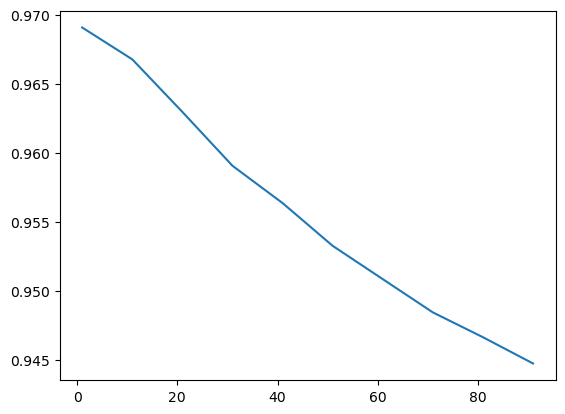

In [43]:
if __name__=="__main__":
    # train_matrix = train_matrix.to(DEVICE)
    # test_matrix = test_matrix.to(DEVICE)
    dist_matrix=euc_dist_matrix(test_matrix,train_matrix)
    print(dist_matrix.size())
    
    scores=[]
    for k in range(1,100,10):
        res=[]
        # k=10

        # mps.synchronize()
        # dist_matrix=dist_matrix.cpu() 

        for i in range(len(dist_matrix)):
            topk_points=torch.topk(dist_matrix[i],k,largest=False).indices
            pridict_label=torch.bincount(torch.tensor([train_labels[idx] for idx in topk_points])).argmax()
            res.append(pridict_label)

        # print(len(res))
        # print(len(test_labels))
        # assert len(res)==len(test_labels)
        # print(classification_report(y_true=test_labels,y_pred=res,output_dict=True)["weighted avg"]["f1-score"])
        scores.append(classification_report(y_true=test_labels,y_pred=res,output_dict=True)["weighted avg"]["f1-score"])
        
    plt.plot(range(1,100,10),scores)